In [108]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()


import utils
import utils.logging_config
utils.logging_config.set_log_level("info")
import logging
logger = logging.getLogger("task1")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
DATA_ROOT = Path('data')
DATA_NAME = 'data.txt'
CACHE_ROOT = Path('.cache')

In [110]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

20:14:58 - utils.load - Loaded 50010 rows and 10 columns from data/data.txt


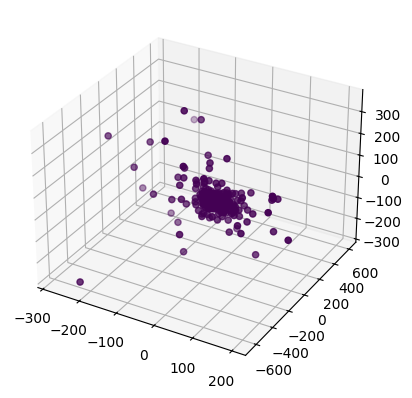

In [111]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()

### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- spherical distribution

$\implies$ this seems to be a **globular cluster**

20:15:00 - task1 - Considering a globular cluster - total mass of particles: 4622219.258999999, maximum radius of particles: 724.689657812915
20:15:00 - utils.units - Set scales: M_SCALE = 0.011 solMass, R_SCALE = 0.014 pc


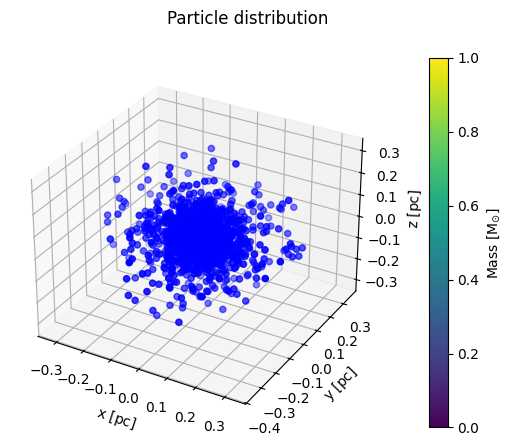

In [112]:
# Set G = 1
G = 1


# Since we have a globular cluster, we can use typical values
M_TOT = 5* 1e4 * u.M_sun
R_TOT = 10 * u.pc

# Rescale the units of the particles
M_particles = particles[:,3].sum()
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))
logger.info(f"Considering a globular cluster - total mass of particles: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)



### Plot again with scales
reduced = utils.remove_outliers(particles.copy())
positions = utils.apply_units(reduced[:, :3], "position")
masses = utils.apply_units(reduced[:, 3], "mass")
utils.particles_plot_3d(positions, masses, title="Particle distribution")


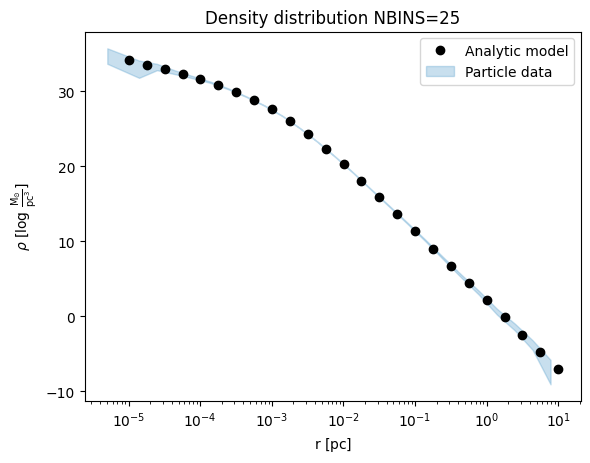

In [113]:
NBINS = 25
all_r = utils.r_distribution(particles)
rbins = np.logspace(np.log10(np.min(2*all_r)), np.log10(np.max(all_r)), NBINS, endpoint=True)


## Using the Hernquist model with parameters M and a
a = utils.half_mass_radius(particles) / (1 + np.sqrt(2))
logger.debug(f"Scale length: {a=:.2g}, total mass: {M_particles=:.2g}")
rho_t = utils.model_density_distribution(rbins, M_particles, a)

## Numerical density distribution
rho, err = utils.density_distribution(rbins, particles, ret_error=True)
# since we are using a logarithmic scale, the error should be scaled accordingly:
# the error of log(rho) is delta=dlog/drho * err
err = err * 1 / rho * np.log(10)

## Add the units
rho = utils.apply_units(rho, "density")
# err = utils.apply_units(err, "density")
rho_t = utils.apply_units(rho_t, "density")
rbins = utils.apply_units(rbins, "position")


plt.figure()
plt.title(f'Density distribution {NBINS=}')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("R")
plt.xlabel(f'r [{rbins.unit:latex}]')
plt.ylabel(f'$\\rho$ [log {rho.unit:latex}]')

plt.plot(rbins, np.log(rho_t.value), 'o', label="Analytic model", color="black", zorder=10)

# since we used the value between the bins we should shift the values to the center of the bins
rbins = rbins.value
rbins -= np.diff(rbins, prepend=0) / 2
plt.fill_between(rbins, np.log(rho.value) - err, np.log(rho.value) + err, alpha=0.3, label="Particle data", color=plt.cm.Blues(0.6))

plt.legend()
plt.show()

In [114]:
### Direct N body force computation and comparison with analytical model
epsilon = utils.mean_interparticle_distance(particles)


epsilon_range = np.logspace(-3, 3, 7)
n_squared_forces = []
for e in epsilon_range:
    n_particles = particles.shape[0]
    cache_file = CACHE_ROOT / f"n_squared_forces__n_{n_particles}__softening_multiplier_{e:.0f}.npy"
    try:
        f = np.load(cache_file)
    except FileNotFoundError:
        f = utils.n_body_forces(particles, G, e * epsilon)
        np.save(cache_file, f)
        logger.debug(f"Saved forces to {cache_file}")
    n_squared_forces.append(f)

analytical_force = utils.analytical_forces(particles)

20:15:05 - utils.particles - Found mean interparticle distance: 0.010402746349924056


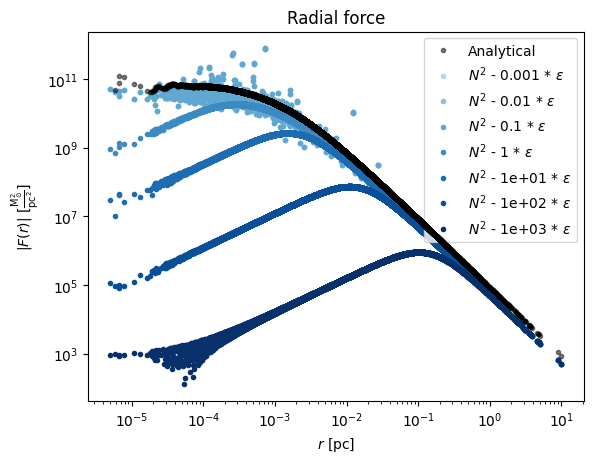

In [115]:
SKIP_N = 1

## Plot the radial force behaviour
r = np.linalg.norm(particles[:,:3], axis=1)
r = utils.apply_units(r, "position")

plt.figure()
f_analytical = np.linalg.norm(analytical_force, axis=1)
f_analytical = utils.apply_units(f_analytical, "force")

plt.plot(r[::SKIP_N], f_analytical[::SKIP_N], '.', label="Analytical", zorder=10, alpha=0.5, color='black')

colors = plt.cm.Blues(np.linspace(0.3,1,len(epsilon_range)))
for e, f, c in zip(epsilon_range, n_squared_forces, colors):
    # print((np.log(e)+10) * 10)
    f_abs = np.linalg.norm(f, axis=1)
    f_abs = utils.apply_units(f_abs, "force")
    plt.plot(r[::SKIP_N], f_abs[::SKIP_N], '.', label=f"$N^2$ - {e:.1g} * $\\epsilon$", color=c)


plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$r$ [{r.unit:latex}]')
plt.ylabel(f'$|F(r)|$ [{f_analytical.unit:latex}]')
plt.legend()
plt.show()

In [116]:
## For fun, do this with the mesh solver as well:
"""
particles = utils.remove_outliers(particles)
r = np.linalg.norm(particles[:,:3], axis=1)
r = utils.apply_units(r, "position")

plt.figure()
f_nsquare = utils.analytical_forces(particles)
f_abs = np.linalg.norm(f_nsquare, axis=1)
f_abs = utils.apply_units(f_abs, "force")
plt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], '.', label="N^2")

f_mesh = utils.mesh_forces(particles, G, 405, utils.particle_to_cells_nn)
f_abs = np.linalg.norm(f_mesh, axis=1)
f_abs = utils.apply_units(f_abs, "force")
plt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], '.', label="Mesh")

plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$r$ [{r.unit}]')
plt.ylabel(f'$F_r(r) [{f_analytical.unit}]$')
plt.legend()
plt.show()
"""

'\nparticles = utils.remove_outliers(particles)\nr = np.linalg.norm(particles[:,:3], axis=1)\nr = utils.apply_units(r, "position")\n\nplt.figure()\nf_nsquare = utils.analytical_forces(particles)\nf_abs = np.linalg.norm(f_nsquare, axis=1)\nf_abs = utils.apply_units(f_abs, "force")\nplt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], \'.\', label="N^2")\n\nf_mesh = utils.mesh_forces(particles, G, 405, utils.particle_to_cells_nn)\nf_abs = np.linalg.norm(f_mesh, axis=1)\nf_abs = utils.apply_units(f_abs, "force")\nplt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], \'.\', label="Mesh")\n\nplt.title(\'Radial force\')\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.xlabel(f\'$r$ [{r.unit}]\')\nplt.ylabel(f\'$F_r(r) [{f_analytical.unit}]$\')\nplt.legend()\nplt.show()\n'

#### Discussion
- basic $N^2$ matches analytical solution without dropoff. but: noisy data from "bad" samples
- $N^2$ with softening matches analytical solution but has a dropoff. No noisy data.
    - softening $\approx 1 \varepsilon$ is a sweet spot since the dropoff is "late"

### Relaxation time

For an estimate of the crossing time we use the half mass radius and the circular velocity at the half mass radius.

$\implies$ the crossing time is of order radius / velocity

In [117]:
## Relaxation timescale (using the velocity at the half mass radius)

# enclosed mass at half mass radius
m_half = np.sum(particles[:, 3]) / 2
r_half = utils.half_mass_radius(particles)

# set the units
m_half = utils.apply_units(m_half, "mass")
r_half = utils.apply_units(r_half, "position")
# finally add a unit to G
true_G = 4.3e-3 * (u.pc / u.M_sun) * (u.km / u.s)**2

# crossing time
v_c = np.sqrt(true_G * m_half / r_half)
logger.info(f"Circular velocity @ HM {v_c}")
r_tot = np.max(np.linalg.norm(particles[:, :3], axis=1))
r_tot = utils.apply_units(r_tot, "position")
t_c = r_tot / v_c
t_c = t_c.to(u.Myr)
logger.info(f"Crossing time for half mass system: {t_c:.2g}")

## Using the relaxation timescale formula
n = particles.shape[0]
n_relax = n / (8 * np.log(n))
t_rel = t_c * n_relax
t_rel = t_rel.to(u.Myr)

logger.info(f"Relaxation timescale: {t_rel:.2g}")


20:22:42 - task1 - Circular velocity @ HM 203.1824123982491 km / s
20:22:42 - task1 - Crossing time for half mass system: 0.048 Myr
20:22:42 - task1 - Relaxation timescale: 28 Myr


#### Discussion


The estimate for $n_{relax}$ comes from the contribution of each star-star encounter to the velocity dispersion. This depends on the perpendicular force

![Pasted image 20250118155501.png](<attachment:Pasted image 20250118155501.png>)

The full integration of the force along the path of the star reduces to the main contribution at the closest approach (distance $b$):
$$
\delta v \approx \frac{2 G m}{b} \to \delta v \approx \frac{2 G m}{b + \varepsilon}
$$
$\implies$ a bigger softening length leads to a smaller $\delta v$.

Using $n_{relax} = \frac{v^2}{\delta v^2}$, and knowing that the value of $v^2$ is derived from the Virial theorem (i.e. unaffected by the softening length), we can see that $n_{relax}$ should increase with $\varepsilon$.

##### Effect
- The relaxation time **increases** with increasing softening length
- From the integration over all impact parameters $b$ even $b_{min}$ is chosen to be larger than $\varepsilon$ $\implies$ expect only a small effect on the relaxation time

**In other words:**
The softening dampens the change of velocity => time to relax is longer
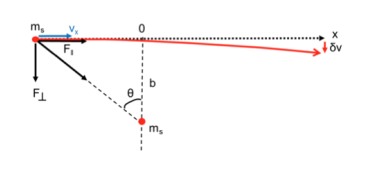

In [118]:
import inspect


In [119]:
print(inspect.getsource(utils.apply_units))

def apply_units(columns: np.array, quantity: str):
    if quantity == "mass":
        return columns * M_SCALE
    elif quantity == "position":
        return columns * R_SCALE
    elif quantity == "volume":
        return columns * R_SCALE**3
    elif quantity == "density":
        return columns * M_SCALE / R_SCALE**3
    
    ## Derived quantities
    elif quantity == "force":
        # using F = GMm/R^2 => F = M_SCALE**2 / R_SCALE**2 (G = 1)
        return columns * M_SCALE**2 / R_SCALE**2
    elif quantity == "velocity":
        # using the Virial theorem: v^2 = GM/R => v = sqrt(GM/R) => v = sqrt(M_SCALE / R_SCALE) (G = 1)
        return columns * np.sqrt(M_SCALE / R_SCALE)
    elif quantity == "time":
        # using the dynamical time: t_dyn = 1/sqrt(G*rho) => t_dyn = sqrt(4/3 * pi * R_SCALE**3 / M_SCALE) (G = 1)
        return columns * np.sqrt(4/3 * np.pi * R_SCALE**3 / M_SCALE)
    else:
        raise ValueError(f"Unknown quantity: {quantity}")



In [120]:
print(inspect.getsource(utils.density_distribution))

def density_distribution(r_bins: np.ndarray, particles: np.ndarray, ret_error: bool = False):
    """
    Computes the radial density distribution of a set of particles.
    Assumes that the particles array has the following columns: x, y, z, m.
    If ret_error is True, it will return the absolute error of the density.
    """
    if particles.shape[1] != 4:
        raise ValueError("Particles array must have 4 columns: x, y, z, m")

    m = particles[:, 3]
    r = np.linalg.norm(particles[:, :3], axis=1)

    m_shells = np.zeros_like(r_bins)
    v_shells = np.zeros_like(r_bins)
    error_relative = np.zeros_like(r_bins)
    r_bins = np.insert(r_bins, 0, 0)

    for i in range(len(r_bins) - 1):
        mask = (r >= r_bins[i]) & (r < r_bins[i + 1])
        m_shells[i] = np.sum(m[mask])
        v_shells[i] = 4/3 * np.pi * (r_bins[i + 1]**3 - r_bins[i]**3)
        if ret_error:
            count = np.count_nonzero(mask)
            if count > 0:
                # the absolute error is th

In [121]:
print(inspect.getsource(utils.analytical_forces))

def analytical_forces(particles: np.ndarray):
    """
    Computes the interparticle forces without computing the n^2 interactions.
    This is done by using newton's second theorem for a spherical mass distribution.
    The force on a particle at radius r is simply the force exerted by a point mass with the enclosed mass.
    Assumes that the particles array has the following columns: x, y, z, m.
    """

    n = particles.shape[0]
    forces = np.zeros((n, 3))

    logger.debug(f"Computing forces for {n} particles using spherical approximation")

    r_particles = np.linalg.norm(particles[:, :3], axis=1)
    for i in range(n):
        r_current = np.linalg.norm(particles[i, 0:3])
        m_current = particles[i, 3]

        m_enclosed = np.sum(particles[r_particles < r_current, 3])

        # the force is the same as the force exerted by a point mass at the center
        f = - m_current * m_enclosed / r_current**2
        forces[i] = f

        if i % 5000 == 0:
            logger.d

In [122]:
print(inspect.getsource(utils.n_body_forces))

def n_body_forces(particles: np.ndarray, G: float = 1, softening: float = 0):
    """
    Computes the gravitational forces between a set of particles.
    Assumes that the particles array has the following columns: x, y, z, m.
    """
    if particles.shape[1] != 4:
        raise ValueError("Particles array must have 4 columns: x, y, z, m")

    x_vec = particles[:, 0:3]
    masses = particles[:, 3]

    n = particles.shape[0]
    forces = np.zeros((n, 3))
    logger.debug(f"Computing forces for {n} particles using n^2 algorithm (using {softening=:.2g})")

    for i in range(n):
        # the current particle is at x_current
        x_current = x_vec[i, :]
        m_current = masses[i]

        # first compute the displacement to all other particles (and its magnitude)
        r_vec = x_vec - x_current
        r = np.linalg.norm(r_vec, axis=1)

        # add softening to the denominator
        r_adjusted = r**2 + softening**2
        # usually with a square root: r' = sqrt(r^2 + soft

In [123]:
print(inspect.getsource(utils.mean_interparticle_distance))

def mean_interparticle_distance(particles: np.ndarray):
    """
    Computes the mean interparticle distance of a set of particles.
    Assumes that the particles array has the following columns: x, y, z ...
    """
    if particles.shape[1] < 3:
        raise ValueError("Particles array must have at least 3 columns: x, y, z")
    

    r_half_mass = half_mass_radius(particles)
    r = np.linalg.norm(particles[:, :3], axis=1)

    n_half_mass = np.sum(r < r_half_mass)
    logger.debug(f"Number of particles within half mass radius: {n_half_mass} of {particles.shape[0]}")

    rho = n_half_mass / (4/3 * np.pi * r_half_mass**3)
    # the mean distance between particles is the inverse of the density

    epsilon = (1 / rho)**(1/3)
    logger.info(f"Found mean interparticle distance: {epsilon}")
    return epsilon

